# Exercises

### Exercise 1
---
Use the sklearn `make_blobs()` function, in the same way that we used in the lesson, to generate a *non linearly separable* dataset with 2 features.  
Fit a linear SVM to the dataset many times, varying the slack hyperparameter $C$, and calculate the model performance in classifying the data.  
What is, approximately, a the best value of the $C$ hyperparameter for this dataset?

In [1]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score

palette = sns.color_palette("tab10")
sns.set_theme("paper", palette=palette, style="whitegrid", font_scale=1.5, font="Times")

In [2]:
# Generate data
X, y = make_blobs(n_samples=300, n_features=2, centers=[[-1, 0], [1, 0]], cluster_std=0.8, random_state=42)

# Evaluate model for each C
results = []
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    scores = cross_val_score(svm.SVC(kernel='linear', C=C), X, y, cv=10, scoring='accuracy')
    results.append({
        'C': C,
        'Mean': scores.mean(),
        'Accuracy': f"{scores.mean():.5f} ± {scores.std():.5f}"
    })

results_df = pd.DataFrame(results).sort_values(by='C', ascending=True).drop(columns='Mean')
results_df

,C,Accuracy
0,0.001,0.89000 ± 0.06333
1,0.010,0.89000 ± 0.05972
2,0.100,0.88333 ± 0.06009
3,1.000,0.88333 ± 0.06009
4,10.000,0.88333 ± 0.06009
5,100.000,0.88333 ± 0.06009


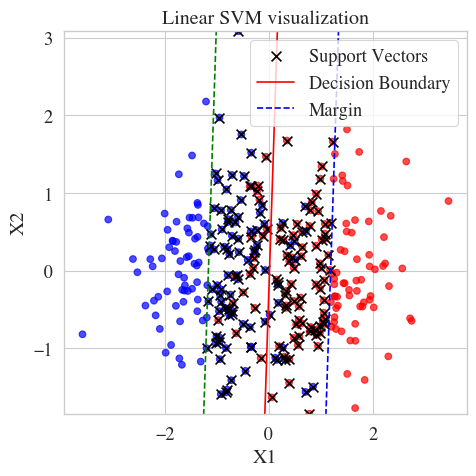

In [3]:
# Fit best linear SVM
model = svm.SVC(kernel='linear', C=0.01)
model.fit(X, y)

# Plot data points and support vectors
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.scatter(*model.support_vectors_.T, s=50, c='k',marker='x', label='Support Vectors')

# Extract hyperplane parameters
w, b = model.coef_[0], model.intercept_[0]
x_line = np.linspace(-2, 2)
y_line = -(w[0] / w[1]) * x_line - b / w[1]
plt.plot(x_line, y_line, 'r', label='Decision Boundary')

# Compute margins
margin = 1 / np.linalg.norm(w)
w_hat = w / np.linalg.norm(w)
margin_offset = w_hat * margin

# Plot margin lines
points = np.c_[x_line, y_line]
plt.plot(*(points + margin_offset).T, 'b--', label='Margin')
plt.plot(*(points - margin_offset).T, 'g--')

# Axis labels and limits
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(X[:, 1].min(), X[:, 1].max())
plt.legend()
plt.title('Linear SVM visualization')
plt.tight_layout()
plt.show()

In the above results, the best $C$ value is $0.01$, as this gives the highest mean accuracy with smallest standard deviation ($0.89000 \pm 0.05972$)

### Exercise 2
---
Repeat exercise 1, but using a non-linear SVM model (the sklearn class `SVC` uses [Radial Basis Functions](https://en.wikipedia.org/wiki/Radial_basis_function) as a default, check its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)). 
To have a fairer assessment of the performance, train the model on a fraction (e.g. 80%) of the data, and test it on the other 20%.
Compare the performance of a linear SVC and a RBF SVC for dataset that are increaslingly non-linearly-separable.


### Exercise 3
---
Use the code below to simulate new data.
Generate data and then decode the stimulus identity, see how the decoding performance change when you change the following:

- The amplitude of the noise in the firing rate
- The amplitude of the stimulus modulation of the firing rate
- The number of neurons

Plot and comment.

## Useful code
---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
n_cells = 20; # number of cells to simulate
n_stim_type = 2; # number of different stimuli
sigma_stim = 0.5 # amplitude of stimulus related modulation
average_firing_rate = 5; # average firing rate across the population

# generate baseline rates from exponential distirbution
cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)

# create stimulus average responses, perturbing the population firng rate profile
# we use a multiplicative modulation in opposite directions for the two stimuli
modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
cell_rate_stim = {1: cell_rate_baseline * (1+modulation),2:cell_rate_baseline * (1-modulation)}
# sets negative firng rate to 0
cell_rate_stim[1][cell_rate_stim[1]<0]=0
cell_rate_stim[2][cell_rate_stim[2]<0]=0

In [ ]:
# simulate spiking activity

s_rate = 10000 # the sampling rate of our emulated recording system
noise_rate = 1 # we are going to add some spike noise non related to the task
n_stim = 100 # number of stimuli

stim_dur = 2 #stimulus duration (in seconds)
is_interval = 3 # interval between stimuli  (in seconds)

stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
np.random.shuffle(stim_type)

time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.

spike_times = []
for cell in range(n_cells):
    spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
    for i,stimulus in enumerate(stim_type):
        stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
        spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)

    spike_times.append(time[spikes>0])



In [ ]:
# save ouput
out_dict = {'spike_times':spike_times,
            'stim_onsets':stim_onsets,
            'stim_type':stim_type,
            'stim_duration':stim_dur
            }

with open('data/simulated_data1.pickle', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
